In [88]:
import tensorflow as tf
from random import choice, shuffle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from collections import defaultdict
import random, math
from __future__ import division

In [80]:
# LOAD DATA

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.', one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [109]:
# BUILDING GRAPH

learning_rate = .01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

n_hidden_1 = 256
n_hidden_2 = 128
n_input = 784

X = tf.placeholder('float', [None, n_input])
keep_prob = tf.placeholder(tf.float32)
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

def encoder(x):
    layer_drop1 = tf.nn.dropout(x, keep_prob)
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(layer_drop1, weights['encoder_h1']), biases['encoder_b1']))
    layer_drop2 = tf.nn.dropout(layer_1, keep_prob)
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_drop2, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
def decoder(x):
    layer_drop1 = tf.nn.dropout(x, keep_prob)
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(layer_drop1, weights['decoder_h1']), biases['decoder_b1']))
    layer_drop2 = tf.nn.dropout(layer_1, keep_prob)
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_drop2, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2 
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# === DIRECT TAKE FROM ENCODER'S OUTPUT FOR CLUSTERING

encoded_X = encoder_op # 128D output.

# ===

y_pred = decoder_op
y_true = X
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAINING

sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
for epoch in range(training_epochs):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={X:batch_xs, keep_prob:.5})
    if epoch % display_step == 0:
        print('Epoch: ', '%04d' % (epoch+1),
              'cost = ', '{:.9f}'.format(c))
print('Optimization Finished!')
print

# GET DIM-REDUCED OUTPUT

Z = sess.run(encoded_X, feed_dict={X:mnist.train.images, keep_prob:1.})

('Epoch: ', '0001', 'cost = ', '0.147859231')
('Epoch: ', '0002', 'cost = ', '0.109573215')
('Epoch: ', '0003', 'cost = ', '0.111675732')
('Epoch: ', '0004', 'cost = ', '0.105503134')
('Epoch: ', '0005', 'cost = ', '0.108217567')
('Epoch: ', '0006', 'cost = ', '0.107860312')
('Epoch: ', '0007', 'cost = ', '0.106146522')
('Epoch: ', '0008', 'cost = ', '0.104600303')
('Epoch: ', '0009', 'cost = ', '0.098469868')
('Epoch: ', '0010', 'cost = ', '0.100609973')
('Epoch: ', '0011', 'cost = ', '0.092984900')
('Epoch: ', '0012', 'cost = ', '0.090369962')
('Epoch: ', '0013', 'cost = ', '0.086961009')
('Epoch: ', '0014', 'cost = ', '0.083921298')
('Epoch: ', '0015', 'cost = ', '0.079983167')
('Epoch: ', '0016', 'cost = ', '0.076307975')
('Epoch: ', '0017', 'cost = ', '0.077306651')
('Epoch: ', '0018', 'cost = ', '0.073804654')
('Epoch: ', '0019', 'cost = ', '0.071962044')
('Epoch: ', '0020', 'cost = ', '0.068388939')
Optimization Finished!



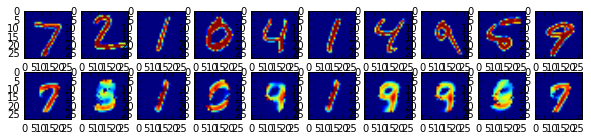

In [89]:
# RECONSTRUCTION TEST

encode_decode = sess.run(y_pred, feed_dict={X:mnist.test.images[:examples_to_show], keep_prob:1.})
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
    a[1][i].imshow(np.reshape(encode_decode[i],(28,28)))
    
sess.close()

In [112]:
%%time

# K-MEANS CLUSTERING

kms = KMeans(n_clusters=10, random_state=7)
kms.fit(Z)

CPU times: user 7 s, sys: 232 ms, total: 7.23 s
Wall time: 6.49 s


In [150]:
# EXAMINE RESULTS FROM K-MEANS INITIALIZATION

# cls2vec = defaultdict(list)
# for i in range(len(kms.labels_)):
#     cls2vec[kms.labels_[i]].append(i)
    
# for i in range(10):
#     sample_ids = [random.choice(cls2vec[i]) for _ in range(10)]
#     print [np.argmax(mnist.train.labels[i]) for i in sample_ids]
#     print

In [196]:
# CLUSTERING FUNCTIONS

MU = kms.cluster_centers_
Q, P = np.random.rand(Z.shape[0],Z.shape[1]), np.random.rand(Z.shape[0],Z.shape[1])

def q(i, j):
    num = math.pow(1 + math.pow(np.linalg.norm(Z[i]-MU[j]), 2), -1)
    denom = sum(math.pow(1 + math.pow(np.linalg.norm(Z[i]-MU[j_prime]), 2), -1)
                for j_prime in range(len(MU)))
    return num/denom

def f(j):
    return Q[:,j].sum()

def p(i, j):
    num = math.pow(Q[i,j], 2) / f(j)
    denom = sum(math.pow(Q[i,j_prime], 2) / f(j_prime) 
                for j_prime in range(len(MU)))
    return num/denom

def z_grad(i):
    return 2 * sum(math.pow(math.pow(np.linalg.norm(Z[i]-MU[j]), 2), -1) * \
                   ((P[i,j] - Q[i,j]) * np.dot(Z[i], MU[j]))
                   for j in range(len(MU)))

def mu_grad(j):
    return -2 * sum(math.pow(math.pow(np.linalg.norm(Z[i]-MU[j]), 2), -1) * \
                    ((P[i,j] - Q[i,j]) * np.dot(Z[i], MU[j]))
                    for j in range(len(Z)))

In [198]:
# HALF-AUTOENCODER GRAPH

pred_Z = tf.placeholder('float', [None, n_hidden_2])
encoder_cost = tf.reduce_mean(tf.pow(pred_Z - encoded_X, 2))
encoder_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(encoder_cost)

def train_half_autoencoder():

    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        total_batch = int(mnist.train.num_examples/batch_size)
        for epoch in range(training_epochs):
            for i in range(total_batch):
                batch_xs, batch_ys = mnist.train.next_batch(batch_size)
                _, c = sess.run([encoder_optimizer, encoder_cost], 
                                feed_dict={X:batch_xs, pred_Z:Z, keep_prob:.5})
    
        return sess.run(encoded_X, feed_dict={X:mnist.train.images, keep_prob:1.})
    

In [ ]:
%%time

n_epochs = 10

for e in range(n_epochs):
    
    print '... at epoch ', e+1
    
    print '... clustering'
    for i in range(len(Z)):
        for j in range(len(MU)):
            Q[i,j] = q(i,j)
            P[i,j] = p(i,j)
    
    for i in range(len(Z)):
        for j in range(len(MU)):
            Z[i] -= z_grad(i)
            MU[j] -= mu_grad(j)
    
    print '... calibrate half-autoencoder'
    Z = train_half_autoencoder()

... at epoch  1
... clustering
